In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import cmath
import pandas as pd

### simulate beam response

In [40]:
def Synthesized_beam(theta_rel, BW = 250, N_ch = 4, nu_c = 1405, c = 3e8, 
                     antanna_position_file = '../antanna_position_EW.xlsx'): 
    """
    Input: 
      theta_rel: float, position relative to phase center 
      use N_ch >= 32 
    
    Output: 
        I_sum_sky
    """
    
    df = pd.read_excel(antanna_position_file, skiprows = range(21, 24))
    ant_pos_EW = df['position'] 
    
    b_arr = np.array([]) # all baselines 
    for i in np.arange(len(ant_pos_EW)):
        b = ant_pos_EW[i+1:] - ant_pos_EW[i]
        b_arr = np.concatenate((b_arr, b), axis=None)
        
    # Fringes 
    #theta_rel = np.linspace(-1*theta_range, theta_range, num=2 * theta_num + 1) # in degree, relative angle from theta_c
    #theta_abs = theta_c + theta_rel # in degree, angle from the zenith  
    
    nu_ch = np.linspace(nu_c-0.5*BW, nu_c+0.5*BW, num=N_ch) # channel frequency
    
    E_arr = np.ones((len(b_arr) * len(nu_ch), len(theta_rel))) # E-field 
    t = 0.0 # reference time
    
    
    # in some functions theta_rel is an array, so those loops are there 
    i = 0
    for b in b_arr: 
        tau_geometry_arr = b / c * np.sin(np.deg2rad(theta_rel)) 
        
        for nu in nu_ch: # MHz 
            fringe_phases = np.array([2 * np.pi * 1e6 * nu * (t - tau_geometry) for tau_geometry in tau_geometry_arr]) # in radian 
            E_arr[i] = np.array([cmath.exp(-1j * phi) for phi in fringe_phases])
 
            i += 1 
    
    
    E_sum = [np.sum(E_arr[:,i]) for i in np.arange(len(theta_rel))] # total -field at each location 
    I_sum_sky = [abs(x * x.conjugate()) for x in E_sum] # power response 
    
    return I_sum_sky 


def Prime_norm(theta_abs, mu_prime = 0, sigma_prime = 3.5/2.355):
    prime = stats.norm.pdf(theta_abs, mu_prime, sigma_prime)  # single dish power response at central frequency 
    prime_norm = prime / stats.norm.pdf(0, mu_prime, sigma_prime)  
    
    return prime_norm

    
def Calculate_I_nearby_beams(theta_abs, main_lobe_space = 1./60, nearby_beam_num=7):
            
    theta_c_arr = np.linspace(-1*main_lobe_space * 256 / 2, main_lobe_space * 256 / 2, num=256)
    index_nearest = np.argmin(abs(theta_abs - theta_c_arr)) 
    theta_c_arr_nearby = theta_c_arr[index_nearest - int(nearby_beam_num/2) : index_nearest + int(nearby_beam_num/2)+1]
    
    theta_rel = abs(theta_c_arr_nearby - theta_abs)
    
    I_sum_sky_norm = Synthesized_beam(theta_rel) / Synthesized_beam(np.array([0]))[0]
    prime_norm = Prime_norm(theta_abs)
    I_tot = prime_norm * I_sum_sky_norm  # Total power response 
    
    return I_tot

### parameters to adjust

In [43]:
my_main_lobe_space = 1./60 # main lobe center spacing 1 arcmin  
my_theta_c_arr = np.linspace(-1*my_main_lobe_space * 256 / 2, my_main_lobe_space * 256 / 2, num=256)
my_plot_angle = 0.5 # zoom in  
my_nearby_beam_num = 7 # how many adjecent beams to include  



<ipython-input-40-a7cb97f7e366>:37: ComplexWarning: Casting complex values to real discards the imaginary part
  E_arr[i] = np.array([cmath.exp(-1j * phi) for phi in fringe_phases])


In [ ]:
my_theta_abs_arr = np.linspace(-1*my_plot_angle, my_plot_angle, num=501) 
my_I_tot_arr = np.zeros((len(my_theta_abs_arr), my_nearby_beam_num)) 

for i in range(len(my_theta_abs_arr)): 
    my_theta_abs = my_theta_abs_arr[i]
    my_I_tot_arr[i] = Calculate_I_nearby_beams(my_theta_abs, main_lobe_space = my_main_lobe_space, nearby_beam_num=my_nearby_beam_num) 
     

<ipython-input-40-a7cb97f7e366>:37: ComplexWarning: Casting complex values to real discards the imaginary part
  E_arr[i] = np.array([cmath.exp(-1j * phi) for phi in fringe_phases])


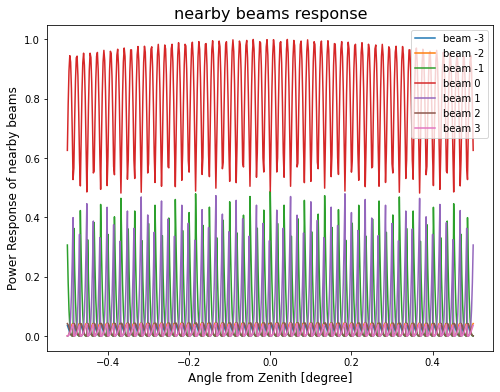

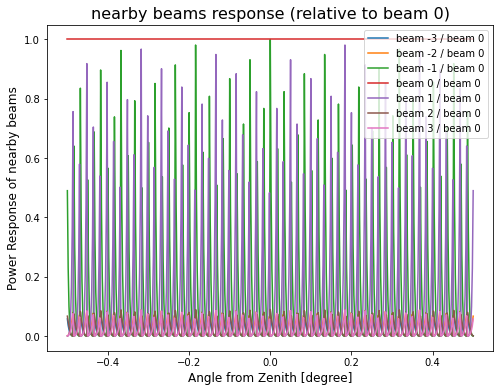

In [44]:
fig1, ax1 = plt.subplots() 
fig1.set_size_inches(8., 6.)

fig2, ax2 = plt.subplots() 
fig2.set_size_inches(8., 6.)

for i in range(my_nearby_beam_num):
    ax1.plot(my_theta_abs_arr, my_I_tot_arr[:, i], label = 'beam %d'%(i-int(my_nearby_beam_num/2)))  
    ax2.plot(my_theta_abs_arr, my_I_tot_arr[:, i] / my_I_tot_arr[:, int(my_nearby_beam_num/2)], label = 'beam %d / beam 0'%(i-int(my_nearby_beam_num/2)))  
    
ax1.legend(loc=1)
ax1.set_xlabel('Angle from Zenith [degree]', fontsize = 12)
ax1.set_ylabel('Power Response of nearby beams', fontsize = 12)
ax1.set_title('nearby beams response', fontsize = 16) 
fig1.savefig('beam_response_zoom.pdf') 

ax2.legend(loc=1)
ax2.set_xlabel('Angle from Zenith [degree]', fontsize = 12)
ax2.set_ylabel('Power Response of nearby beams', fontsize = 12)
ax2.set_title('nearby beams response (relative to beam 0)', fontsize = 16) 
fig2.savefig('beam_response_relative_zoom.pdf') 


# plot beams and main lobes 

my_theta_rel_repeat = np.linspace(-0.15, 0.15, num=300)
I_sum_sky_norm_repeat = Synthesized_beam(my_theta_rel_repeat) / Synthesized_beam(np.array([0]))[0]
